# 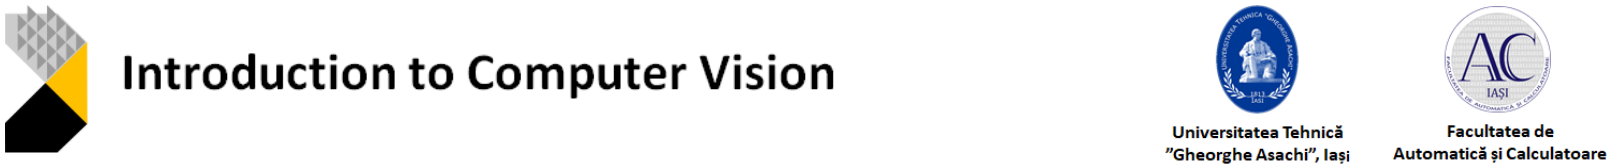

  The Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs.
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 2: License plate text recognition

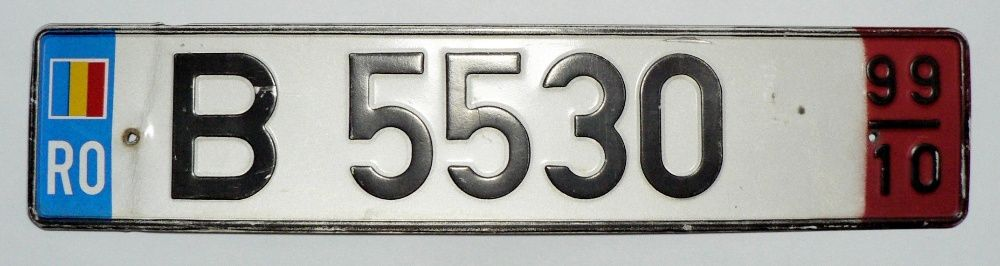

###Label:B
###Prediction output: B
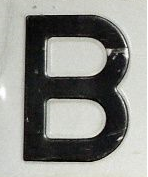

## Week 1: Character classification

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".

#TODO: add dataset at https://drive.google.com/drive/folders/1cgYRzxXDPMXaJrBFrESsmQUuOzjZi3j2?usp=sharing to My Drive

# check for test image
!ls "/content/drive/My Drive/train_letters/a (1).png"

'/content/drive/My Drive/train_letters/a (1).png'


In [30]:
# function used to load dataset
import cv2
import os
import numpy


def load_images_from_folder(folder):
  images = []
  labels = []
  for filename in os.listdir(folder):
    #TODO: read image
    img = cv2.imread(folder + "/" + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if img is not None:
      #TODO: invert image
      inverted_image = cv2.bitwise_not(img)

      #TODO: append image
      images.append(inverted_image)

      #append image label (first letter of image name: a, b, c, ...)
      labels.append(ord(filename[0])-ord('a'))
  return images, labels

In [39]:
#Load images from folder
folder = '/content/drive/My Drive/train_letters'

images, labels = load_images_from_folder(folder)

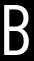

B


In [40]:
#Test if loading was successful
from google.colab.patches import cv2_imshow

cv2_imshow(images[15])
print(chr(labels[15]+65))

### Fourier Descriptors
Let $x[m]$ and $y[m]$ be the coordinates of the mth pixel on the boundary of a given 2D shape containing $N$ pixels, a complex number can be formed as $z[m]=x[m]+jy[m]$, and the Fourier Descriptor (FD) of this shape is defined as the DFT of $z[m]$:

$$Z[k] = DFT[z[m]] = \frac{1}{n}\sum_{m=0}^{N-1}z|m|e^{-j2\pi mk/N}$$

FD can be used as a representation of 2D closed shapes independent of its location, scaling, rotation and starting point. For example, we could use $M < N$ FDs corresponding to the low frequency components of the boundary to represent the 2D shape. The reconstructed shape based on these FDs approximate the shape without the details (corresponding to the high frequency components susceptible to noise). However, note that since the Fourier transform is a complex transform, the frequency spectrum has negative frequencies as well as positive frequencies, with the DC component in the middle. Therefore the inverse transform with $M< N$ components needs to contain both positive and negative terms:

$$ ẑ[m]=\sum_{k = -M/2}^{M/2} Z[k] e^{j2\pi mk/N} (m = 0, ..., N-1)$$




To compute the FD:

1. Find object contour (see cv2.findContours)
2. Create complex numbers using the (x, y) coordinates of the contour points: z = x + jy
3. Compute the Fourier transform for every complex number



In [41]:
# Function to compute the fourier descriptors
def findDescriptor(img):
    """ findDescriptor(img) finds and returns the
    Fourier-Descriptor of the image contour"""
    contour = []
    #Find object contour
    contour, hierarchy = cv2.findContours(
        img,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE,
        contour)

    #TODO: Create complex number using (x, y) coordinates of the contour points
    # 1. extract X and Y vectors from contour
    contour_points = contour[0][:, 0, :]
    x = contour_points[:, 0]
    y = contour_points[:, 1]

    # 2. create a numpy.array of the same size for complex data type (see numpy.empty, dtype=complex)
    contour_complex = np.empty(contour_points.shape[:-1], dtype=complex)

    # 3. populate real & imag parts with extracted X and Y vectors
    contour_complex.real = x
    contour_complex.imag = y

    #TODO: Apply Fourier Transform (see numpy.fft)
    fourier_result = np.fft.fft(contour_complex)

    return fourier_result

#Function that keeps a desired number of fourier descriptors (degree)
def truncate_descriptor(descriptors, degree):
    #this function truncates an unshifted fourier descriptor array and returns one also unshifted
    descriptors = numpy.fft.fftshift(descriptors)
    center_index = len(descriptors) / 2
    descriptors = descriptors[int(center_index - (degree / 2)):int(center_index + (degree / 2))]
    descriptors = numpy.fft.ifftshift(descriptors)
    return descriptors

###Input shape and different number of Fourier Descriptors (10, 50, 300)

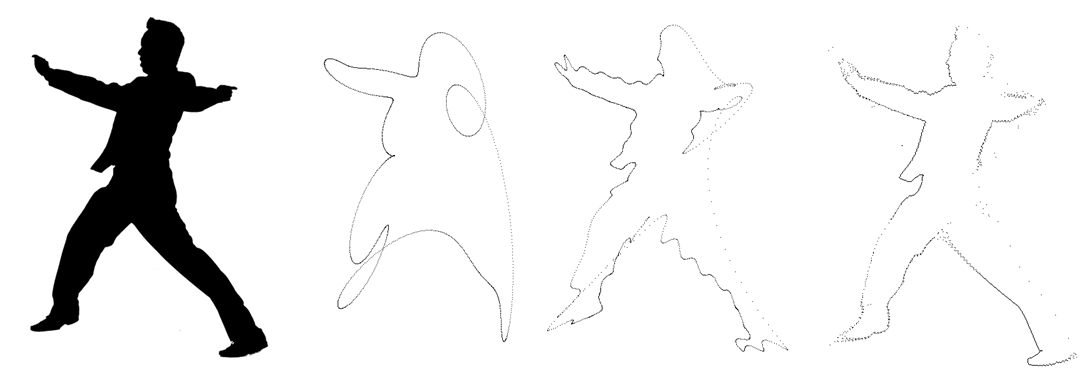

### What are Hu Moments?
**Hu Moments** ( or rather **Hu moment invariants** ) are a set of 7 numbers calculated using **central moments** that are invariant to image transformations. The first 6 moments have been proved to be invariant to **translation**, **scale**, and **rotation**, and **reflection**. While the 7th moment’s sign changes for image reflection.

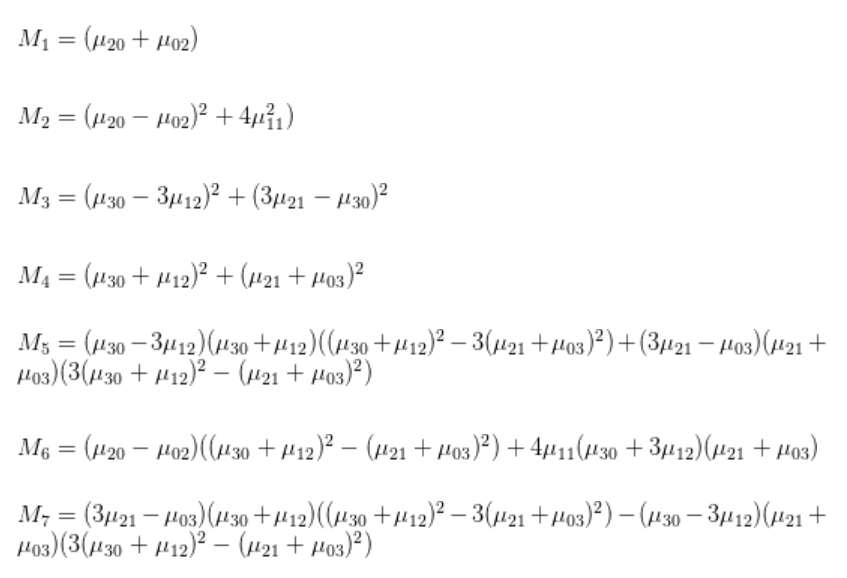

```markdown
Further reading: Analysis of Hu's moment invariants on image scaling and rotation (https://ieeexplore.ieee.org/document/5485542)
```

In [42]:
#TODO: Function that computes Hu Moments
# Steps:
# 1. threshold image (see cv2.threshold)
# 2. calculate moments (see cv2.moments)
# 3. compute Hu Moments (see cv2.HuMoments)

def fd_hu_moments(image):
  #step 1 => threshold
  ret, thresh = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)

  #step2 => moments
  moments = cv2.moments(thresh)

  #step 3 => Hu Moments
  huMoments = cv2.HuMoments(moments)

  return huMoments


### Test Hu Moments by performing geometric transformations

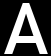

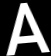

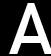

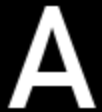

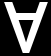

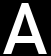

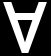

Moment 1
[0.00129882]
[0.00128986]
[0.00129116]
[0.00129373]
[0.00129882]
[0.00129882]
[0.00129882]
Moment 2
[1.10625993e-07]
[1.10788959e-07]
[1.13862619e-07]
[1.11707271e-07]
[1.10625993e-07]
[1.10625993e-07]
[1.10625993e-07]
Moment 3
[1.37731842e-09]
[1.34846005e-09]
[1.3226628e-09]
[1.35360581e-09]
[1.37731842e-09]
[1.37731842e-09]
[1.37731842e-09]
Moment 4
[2.82776304e-12]
[2.79097189e-12]
[2.12367345e-12]
[2.93574739e-12]
[2.82776304e-12]
[2.82776304e-12]
[2.82776304e-12]
Moment 5
[-1.66507315e-22]
[-1.57803823e-22]
[-9.75784141e-23]
[-1.84587726e-22]
[-1.66507315e-22]
[-1.66507315e-22]
[-1.66507315e-22]
Moment 6
[9.18198078e-16]
[8.96918779e-16]
[6.89991315e-16]
[9.7970426e-16]
[9.18198078e-16]
[9.18198078e-16]
[9.18198078e-16]
Moment 7
[-5.84681611e-23]
[-6.64374663e-23]
[5.60943713e-23]
[-1.32815707e-23]
[5.84681611e-23]
[5.84681611e-23]
[-5.84681611e-23]


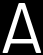

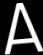

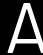

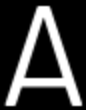

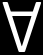

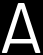

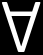

Moment 1
[0.00188779]
[0.00183301]
[0.00186338]
[0.0018488]
[0.00188779]
[0.00188779]
[0.00188779]
Moment 2
[3.80966336e-07]
[3.77397746e-07]
[4.34931065e-07]
[3.78336486e-07]
[3.80966336e-07]
[3.80966336e-07]
[3.80966336e-07]
Moment 3
[3.67811256e-09]
[3.31169426e-09]
[3.20183567e-09]
[3.46451083e-09]
[3.67811256e-09]
[3.67811256e-09]
[3.67811256e-09]
Moment 4
[2.32769398e-14]
[2.0919339e-12]
[4.87163582e-12]
[1.5269417e-12]
[2.32769398e-14]
[2.32769398e-14]
[2.32769398e-14]
Moment 5
[-1.93019547e-25]
[1.44497074e-22]
[-3.08374908e-22]
[1.0797294e-22]
[-1.93019547e-25]
[-1.93019547e-25]
[-1.93019547e-25]
Moment 6
[1.37130348e-17]
[1.17343624e-15]
[-3.20348017e-15]
[9.24934478e-16]
[1.37130348e-17]
[1.37130348e-17]
[1.37130348e-17]
Moment 7
[-9.5556979e-26]
[-9.71501219e-23]
[-5.24493941e-22]
[-2.59999242e-23]
[9.5556979e-26]
[9.5556979e-26]
[-9.5556979e-26]


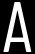

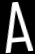

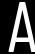

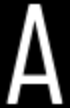

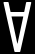

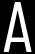

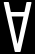

Moment 1
[0.00179704]
[0.00175265]
[0.00178949]
[0.00175195]
[0.00179704]
[0.00179704]
[0.00179704]
Moment 2
[1.19147359e-06]
[1.12034594e-06]
[1.19573815e-06]
[1.11935844e-06]
[1.19147359e-06]
[1.19147359e-06]
[1.19147359e-06]
Moment 3
[1.67106376e-09]
[1.66119954e-09]
[1.59507651e-09]
[1.61925433e-09]
[1.67106376e-09]
[1.67106376e-09]
[1.67106376e-09]
Moment 4
[2.32025943e-11]
[3.28860262e-11]
[2.37150483e-11]
[2.86913447e-11]
[2.32025943e-11]
[2.32025943e-11]
[2.32025943e-11]
Moment 5
[4.49909105e-21]
[7.64472976e-21]
[4.56221273e-21]
[6.15383869e-21]
[4.49909105e-21]
[4.49909105e-21]
[4.49909105e-21]
Moment 6
[2.50966199e-14]
[3.46654734e-14]
[2.57024571e-14]
[3.02640651e-14]
[2.50966199e-14]
[2.50966199e-14]
[2.50966199e-14]
Moment 7
[-7.95006012e-22]
[-8.00135767e-22]
[6.78550568e-22]
[-6.12097206e-22]
[7.95006012e-22]
[7.95006012e-22]
[-7.95006012e-22]


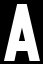

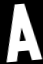

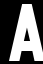

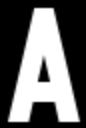

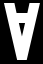

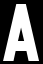

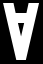

Moment 1
[0.0010331]
[0.00102793]
[0.00102801]
[0.00103066]
[0.0010331]
[0.0010331]
[0.0010331]
Moment 2
[3.39097675e-07]
[3.38120795e-07]
[3.42470798e-07]
[3.36952144e-07]
[3.39097675e-07]
[3.39097675e-07]
[3.39097675e-07]
Moment 3
[3.30814176e-10]
[3.27972217e-10]
[3.11146906e-10]
[3.29791047e-10]
[3.30814176e-10]
[3.30814176e-10]
[3.30814176e-10]
Moment 4
[5.49996628e-12]
[6.61862913e-12]
[6.02685535e-12]
[5.54210825e-12]
[5.49996628e-12]
[5.49996628e-12]
[5.49996628e-12]
Moment 5
[2.34597525e-22]
[3.0819356e-22]
[2.46462819e-22]
[2.36931593e-22]
[2.34597525e-22]
[2.34597525e-22]
[2.34597525e-22]
Moment 6
[3.20271749e-15]
[3.84632327e-15]
[3.3909331e-15]
[3.21699777e-15]
[3.20271749e-15]
[3.20271749e-15]
[3.20271749e-15]
Moment 7
[1.48233488e-24]
[-1.03980372e-23]
[8.58504479e-23]
[1.5222585e-24]
[-1.48233488e-24]
[-1.48233488e-24]
[1.48233488e-24]


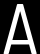

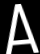

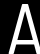

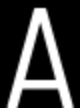

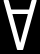

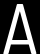

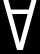

Moment 1
[0.00181497]
[0.00175585]
[0.00180289]
[0.00177272]
[0.00181497]
[0.00181497]
[0.00181497]
Moment 2
[7.33181337e-07]
[7.04849726e-07]
[7.44239153e-07]
[7.10086773e-07]
[7.33181337e-07]
[7.33181337e-07]
[7.33181337e-07]
Moment 3
[2.45727956e-09]
[2.27116183e-09]
[2.31193248e-09]
[2.32708802e-09]
[2.45727956e-09]
[2.45727956e-09]
[2.45727956e-09]
Moment 4
[2.51822584e-12]
[1.2723863e-11]
[3.57045015e-12]
[8.883884e-12]
[2.51822584e-12]
[2.51822584e-12]
[2.51822584e-12]
Moment 5
[1.6692517e-22]
[1.2647528e-21]
[1.8936258e-22]
[1.26173844e-21]
[1.6692517e-22]
[1.6692517e-22]
[1.6692517e-22]
Moment 6
[2.00233294e-15]
[8.01516418e-15]
[2.31863303e-15]
[7.44490232e-15]
[2.00233294e-15]
[2.00233294e-15]
[2.00233294e-15]
Moment 7
[-1.06662339e-22]
[-1.75467464e-21]
[2.63387363e-22]
[-1.99111075e-22]
[1.06662339e-22]
[1.06662339e-22]
[-1.06662339e-22]


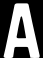

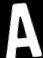

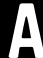

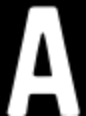

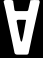

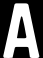

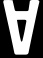

Moment 1
[0.00111951]
[0.00110693]
[0.00111404]
[0.00111514]
[0.00111951]
[0.00111951]
[0.00111951]
Moment 2
[3.16412709e-07]
[3.07108353e-07]
[3.21020512e-07]
[3.1186165e-07]
[3.16412709e-07]
[3.16412709e-07]
[3.16412709e-07]
Moment 3
[3.65589037e-10]
[3.49404732e-10]
[3.37845223e-10]
[3.57706218e-10]
[3.65589037e-10]
[3.65589037e-10]
[3.65589037e-10]
Moment 4
[7.74414446e-13]
[9.14038825e-13]
[1.07733264e-12]
[6.795171e-13]
[7.74414446e-13]
[7.74414446e-13]
[7.74414446e-13]
Moment 5
[1.17898225e-23]
[1.14013547e-23]
[3.0478019e-24]
[1.01757234e-23]
[1.17898225e-23]
[1.17898225e-23]
[1.17898225e-23]
Moment 6
[4.18528566e-16]
[4.09439584e-16]
[3.24975926e-16]
[3.73904863e-16]
[4.18528566e-16]
[4.18528566e-16]
[4.18528566e-16]
Moment 7
[5.54893061e-24]
[-1.16975114e-23]
[2.03261665e-23]
[2.9477933e-24]
[-5.54893061e-24]
[-5.54893061e-24]
[5.54893061e-24]


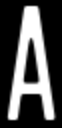

Moment 1
[0.00177131]
[0.00173327]
[0.00176324]
[0.00175407]
[0.00177131]
[0.00177131]
[0.00177131]
Moment 2
[1.81264379e-06]
[1.72270546e-06]
[1.81687058e-06]
[1.77768211e-06]
[1.81264379e-06]
[1.81264379e-06]
[1.81264379e-06]
Moment 3
[6.99343485e-10]
[6.88440059e-10]
[6.36126889e-10]
[6.81280701e-10]
[6.99343485e-10]
[6.99343485e-10]
[6.99343485e-10]
Moment 4
[2.17021474e-11]
[2.60105824e-11]
[1.94821944e-11]
[2.1671773e-11]
[2.17021474e-11]
[2.17021474e-11]
[2.17021474e-11]
Moment 5
[2.65905072e-21]
[3.47362465e-21]
[1.86197928e-21]
[2.63099791e-21]
[2.65905072e-21]
[2.65905072e-21]
[2.65905072e-21]
Moment 6
[2.91135707e-14]
[3.40872102e-14]
[2.35329533e-14]
[2.88800141e-14]
[2.91135707e-14]
[2.91135707e-14]
[2.91135707e-14]
Moment 7
[2.78714189e-22]
[2.20760001e-22]
[1.11217153e-21]
[1.10717683e-22]
[-2.78714189e-22]
[-2.78714189e-22]
[2.78714189e-22]


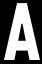

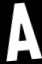

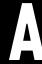

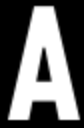

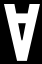

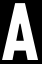

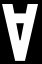

Moment 1
[0.00108022]
[0.00107827]
[0.00107401]
[0.00108009]
[0.00108022]
[0.00108022]
[0.00108022]
Moment 2
[3.73865592e-07]
[3.68056587e-07]
[3.88333355e-07]
[3.70318342e-07]
[3.73865592e-07]
[3.73865592e-07]
[3.73865592e-07]
Moment 3
[3.75858459e-10]
[3.80302292e-10]
[3.2873266e-10]
[3.76934525e-10]
[3.75858459e-10]
[3.75858459e-10]
[3.75858459e-10]
Moment 4
[9.941588e-12]
[9.71951177e-12]
[1.03308902e-11]
[8.6054958e-12]
[9.941588e-12]
[9.941588e-12]
[9.941588e-12]
Moment 5
[6.07333509e-22]
[5.90824287e-22]
[5.50471686e-22]
[4.90102396e-22]
[6.07333509e-22]
[6.07333509e-22]
[6.07333509e-22]
Moment 6
[6.07690849e-15]
[5.8952344e-15]
[5.96625718e-15]
[5.23670334e-15]
[6.07690849e-15]
[6.07690849e-15]
[6.07690849e-15]
Moment 7
[-2.13652281e-23]
[-1.08194403e-23]
[2.43798257e-22]
[3.32248015e-24]
[2.13652281e-23]
[2.13652281e-23]
[-2.13652281e-23]


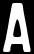

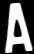

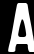

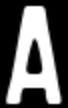

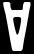

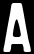

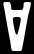

Moment 1
[0.00125047]
[0.0012395]
[0.00124493]
[0.00124143]
[0.00125047]
[0.00125047]
[0.00125047]
Moment 2
[6.01283926e-07]
[5.90733378e-07]
[6.12312772e-07]
[5.92720331e-07]
[6.01283926e-07]
[6.01283926e-07]
[6.01283926e-07]
Moment 3
[3.79136886e-10]
[3.59914831e-10]
[3.37111249e-10]
[3.64311417e-10]
[3.79136886e-10]
[3.79136886e-10]
[3.79136886e-10]
Moment 4
[4.29028249e-12]
[4.15122856e-12]
[4.29572223e-12]
[4.36750409e-12]
[4.29028249e-12]
[4.29028249e-12]
[4.29028249e-12]
Moment 5
[1.66047473e-22]
[1.4879967e-22]
[8.98176281e-23]
[1.69228326e-22]
[1.66047473e-22]
[1.66047473e-22]
[1.66047473e-22]
Moment 6
[3.25230293e-15]
[3.05376078e-15]
[2.4007094e-15]
[3.30737277e-15]
[3.25230293e-15]
[3.25230293e-15]
[3.25230293e-15]
Moment 7
[4.86658846e-23]
[6.00486371e-23]
[1.36585449e-22]
[4.13854497e-23]
[-4.86658846e-23]
[-4.86658846e-23]
[4.86658846e-23]


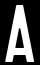

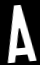

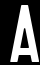

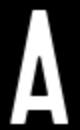

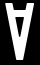

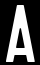

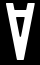

Moment 1
[0.00133245]
[0.00132042]
[0.00133245]
[0.00132828]
[0.00133245]
[0.00133245]
[0.00133245]
Moment 2
[8.48729215e-07]
[8.34686751e-07]
[8.48729215e-07]
[8.41892856e-07]
[8.48729215e-07]
[8.48729215e-07]
[8.48729215e-07]
Moment 3
[5.46391497e-10]
[5.36119959e-10]
[5.46391497e-10]
[5.4378608e-10]
[5.46391497e-10]
[5.46391497e-10]
[5.46391497e-10]
Moment 4
[3.64326585e-11]
[3.87673818e-11]
[3.64326585e-11]
[3.70376676e-11]
[3.64326585e-11]
[3.64326585e-11]
[3.64326585e-11]
Moment 5
[5.13796024e-21]
[5.58801061e-21]
[5.13796024e-21]
[5.25615599e-21]
[5.13796024e-21]
[5.13796024e-21]
[5.13796024e-21]
Moment 6
[3.35509469e-14]
[3.54133425e-14]
[3.35509469e-14]
[3.39827644e-14]
[3.35509469e-14]
[3.35509469e-14]
[3.35509469e-14]
Moment 7
[-1.54995217e-22]
[1.0279626e-22]
[-1.54995217e-22]
[-3.78213664e-23]
[1.54995217e-22]
[1.54995217e-22]
[-1.54995217e-22]


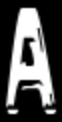

Moment 1
[0.00139598]
[0.00140046]
[0.0013839]
[0.00138977]
[0.00139598]
[0.00139598]
[0.00139598]
Moment 2
[8.70308808e-07]
[8.84801584e-07]
[8.61848191e-07]
[8.64393739e-07]
[8.70308808e-07]
[8.70308808e-07]
[8.70308808e-07]
Moment 3
[3.33558543e-10]
[3.46710953e-10]
[3.00897724e-10]
[3.21000984e-10]
[3.33558543e-10]
[3.33558543e-10]
[3.33558543e-10]
Moment 4
[8.91284855e-14]
[5.84768516e-14]
[5.76292148e-13]
[1.90758976e-13]
[8.91284855e-14]
[8.91284855e-14]
[8.91284855e-14]
Moment 5
[-4.78329187e-25]
[1.38747226e-25]
[6.01190637e-24]
[-1.44276709e-24]
[-4.78329187e-25]
[-4.78329187e-25]
[-4.78329187e-25]
Moment 6
[8.10349239e-17]
[2.92850356e-18]
[-4.365352e-16]
[1.70513773e-16]
[8.10349239e-17]
[8.10349239e-17]
[8.10349239e-17]
Moment 7
[8.58458676e-26]
[2.23783237e-25]
[-4.63108762e-24]
[3.82961833e-25]
[-8.58458676e-26]
[-8.58458676e-26]
[8.58458676e-26]


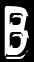

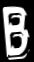

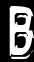

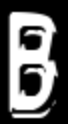

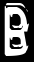

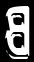

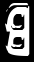

Moment 1
[0.00137017]
[0.00135178]
[0.00137017]
[0.00135514]
[0.00137017]
[0.00137017]
[0.00137017]
Moment 2
[8.37549085e-07]
[8.03315307e-07]
[8.37549085e-07]
[8.20372538e-07]
[8.37549085e-07]
[8.37549085e-07]
[8.37549085e-07]
Moment 3
[3.88195752e-11]
[3.76433637e-11]
[3.88195752e-11]
[4.01187663e-11]
[3.88195752e-11]
[3.88195752e-11]
[3.88195752e-11]
Moment 4
[9.38689004e-12]
[8.24830292e-12]
[9.38689004e-12]
[9.94893377e-12]
[9.38689004e-12]
[9.38689004e-12]
[9.38689004e-12]
Moment 5
[1.68820546e-22]
[1.34671319e-22]
[1.68820546e-22]
[1.84775001e-22]
[1.68820546e-22]
[1.68820546e-22]
[1.68820546e-22]
Moment 6
[6.00766377e-15]
[5.25160807e-15]
[6.00766377e-15]
[6.20892635e-15]
[6.00766377e-15]
[6.00766377e-15]
[6.00766377e-15]
Moment 7
[-6.00651646e-23]
[-5.46619711e-23]
[-6.00651646e-23]
[-7.32494672e-23]
[6.00651646e-23]
[6.00651646e-23]
[-6.00651646e-23]


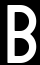

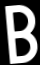

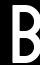

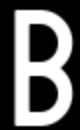

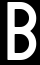

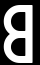

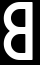

Moment 1
[0.00134665]
[0.00137579]
[0.00136877]
[0.00136992]
[0.00134665]
[0.00134665]
[0.00134665]
Moment 2
[5.69848622e-07]
[6.12469879e-07]
[6.20770813e-07]
[6.1339069e-07]
[5.69848622e-07]
[5.69848622e-07]
[5.69848622e-07]
Moment 3
[3.07084038e-11]
[3.69706707e-11]
[2.59991083e-11]
[3.48183131e-11]
[3.07084038e-11]
[3.07084038e-11]
[3.07084038e-11]
Moment 4
[6.84159611e-13]
[1.53754824e-12]
[4.41475992e-13]
[1.24959184e-12]
[6.84159611e-13]
[6.84159611e-13]
[6.84159611e-13]
Moment 5
[-6.84860481e-25]
[-5.80214805e-24]
[3.79149763e-25]
[-6.05662864e-24]
[-6.84860481e-25]
[-6.84860481e-25]
[-6.84860481e-25]
Moment 6
[-3.06185728e-16]
[-9.06184732e-16]
[-1.06404529e-16]
[-8.48444237e-16]
[-3.06185728e-16]
[-3.06185728e-16]
[-3.06185728e-16]
Moment 7
[3.06022075e-24]
[1.00358281e-23]
[1.44682972e-24]
[5.59063258e-24]
[-3.06022075e-24]
[-3.06022075e-24]
[3.06022075e-24]


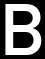

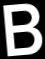

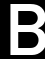

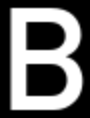

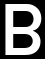

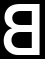

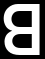

Moment 1
[0.001268]
[0.00126658]
[0.0012758]
[0.00128077]
[0.001268]
[0.001268]
[0.001268]
Moment 2
[1.53949644e-07]
[1.64590319e-07]
[1.6568282e-07]
[1.68474886e-07]
[1.53949644e-07]
[1.53949644e-07]
[1.53949644e-07]
Moment 3
[1.38660766e-11]
[1.47330364e-11]
[1.14072886e-11]
[1.42311802e-11]
[1.38660766e-11]
[1.38660766e-11]
[1.38660766e-11]
Moment 4
[1.50047359e-13]
[2.39367662e-13]
[3.82509157e-13]
[5.8778877e-13]
[1.50047359e-13]
[1.50047359e-13]
[1.50047359e-13]
Moment 5
[-8.20686241e-26]
[2.74712931e-25]
[-5.96979282e-25]
[1.684557e-24]
[-8.20686241e-26]
[-8.20686241e-26]
[-8.20686241e-26]
Moment 6
[5.87446629e-17]
[7.94143664e-17]
[1.34586375e-16]
[1.18763127e-16]
[5.87446629e-17]
[5.87446629e-17]
[5.87446629e-17]
Moment 7
[2.00267545e-25]
[3.55804285e-25]
[5.31072379e-25]
[2.28722141e-25]
[-2.00267545e-25]
[-2.00267545e-25]
[2.00267545e-25]


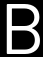

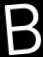

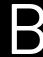

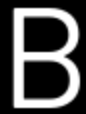

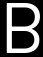

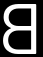

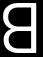

Moment 1
[0.00193028]
[0.00188316]
[0.00199543]
[0.00188747]
[0.00193028]
[0.00193028]
[0.00193028]
Moment 2
[4.08783544e-07]
[3.91366699e-07]
[5.2769136e-07]
[4.09790387e-07]
[4.08783544e-07]
[4.08783544e-07]
[4.08783544e-07]
Moment 3
[5.45527055e-11]
[4.63223479e-11]
[3.75207656e-11]
[5.05779672e-11]
[5.45527055e-11]
[5.45527055e-11]
[5.45527055e-11]
Moment 4
[2.32895328e-12]
[7.81671099e-13]
[5.07870449e-12]
[1.16845246e-12]
[2.32895328e-12]
[2.32895328e-12]
[2.32895328e-12]
Moment 5
[2.60129362e-23]
[1.97584404e-24]
[-3.77442721e-23]
[8.7740784e-24]
[2.60129362e-23]
[2.60129362e-23]
[2.60129362e-23]
Moment 6
[4.57605709e-16]
[4.54958182e-16]
[3.20098767e-15]
[2.03114501e-16]
[4.57605709e-16]
[4.57605709e-16]
[4.57605709e-16]
Moment 7
[-3.52889948e-24]
[4.26848842e-24]
[5.90800233e-23]
[-1.92376346e-24]
[3.52889948e-24]
[3.52889948e-24]
[-3.52889948e-24]


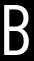

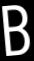

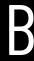

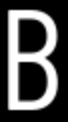

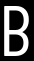

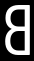

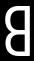

Moment 1
[0.00178263]
[0.00176149]
[0.00178263]
[0.00170772]
[0.00178263]
[0.00178263]
[0.00178263]
Moment 2
[9.63839222e-07]
[9.74197694e-07]
[9.63839222e-07]
[8.96516164e-07]
[9.63839222e-07]
[9.63839222e-07]
[9.63839222e-07]
Moment 3
[4.21714541e-11]
[3.78357717e-11]
[4.21714541e-11]
[3.30288752e-11]
[4.21714541e-11]
[4.21714541e-11]
[4.21714541e-11]
Moment 4
[2.81381378e-12]
[3.35940663e-12]
[2.81381378e-12]
[7.97066289e-13]
[2.81381378e-12]
[2.81381378e-12]
[2.81381378e-12]
Moment 5
[2.15338932e-23]
[3.67139317e-23]
[2.15338932e-23]
[4.07822788e-24]
[2.15338932e-23]
[2.15338932e-23]
[2.15338932e-23]
Moment 6
[1.31156952e-17]
[2.06140683e-15]
[1.31156952e-17]
[3.13082936e-16]
[1.31156952e-17]
[1.31156952e-17]
[1.31156952e-17]
Moment 7
[-2.18130333e-23]
[9.3034095e-24]
[-2.18130333e-23]
[-3.05745347e-25]
[2.18130333e-23]
[2.18130333e-23]
[-2.18130333e-23]


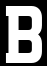

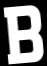

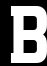

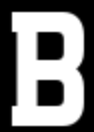

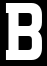

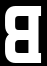

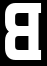

Moment 1
[0.00101644]
[0.00103093]
[0.00101644]
[0.00104337]
[0.00101644]
[0.00101644]
[0.00101644]
Moment 2
[2.05689143e-07]
[2.17515174e-07]
[2.05689143e-07]
[2.2385183e-07]
[2.05689143e-07]
[2.05689143e-07]
[2.05689143e-07]
Moment 3
[9.21952792e-12]
[1.21342864e-11]
[9.21952792e-12]
[1.2280779e-11]
[9.21952792e-12]
[9.21952792e-12]
[9.21952792e-12]
Moment 4
[2.92583314e-13]
[6.39346797e-13]
[2.92583314e-13]
[7.04199746e-13]
[2.92583314e-13]
[2.92583314e-13]
[2.92583314e-13]
Moment 5
[-3.05983383e-25]
[-1.64166203e-24]
[-3.05983383e-25]
[-1.68198423e-24]
[-3.05983383e-25]
[-3.05983383e-25]
[-3.05983383e-25]
Moment 6
[-1.08810976e-16]
[-2.87755329e-16]
[-1.08810976e-16]
[-3.01861859e-16]
[-1.08810976e-16]
[-1.08810976e-16]
[-1.08810976e-16]
Moment 7
[3.70529265e-25]
[6.90033643e-25]
[3.70529265e-25]
[1.20810139e-24]
[-3.70529265e-25]
[-3.70529265e-25]
[3.70529265e-25]


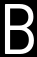

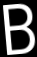

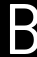

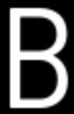

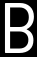

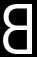

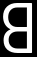

Moment 1
[0.00187121]
[0.00181737]
[0.00195033]
[0.00183485]
[0.00187121]
[0.00187121]
[0.00187121]
Moment 2
[6.7991818e-07]
[6.54959902e-07]
[8.57870482e-07]
[6.64726672e-07]
[6.7991818e-07]
[6.7991818e-07]
[6.7991818e-07]
Moment 3
[3.73830076e-11]
[4.25926837e-11]
[2.40046256e-11]
[4.50656987e-11]
[3.73830076e-11]
[3.73830076e-11]
[3.73830076e-11]
Moment 4
[2.44275246e-12]
[4.06682421e-12]
[6.94008389e-12]
[2.90918507e-12]
[2.44275246e-12]
[2.44275246e-12]
[2.44275246e-12]
Moment 5
[2.27829592e-23]
[4.0305175e-23]
[-2.97993535e-23]
[3.26645176e-23]
[2.27829592e-23]
[2.27829592e-23]
[2.27829592e-23]
Moment 6
[1.15968197e-15]
[2.68445976e-15]
[5.60507294e-15]
[1.41531494e-15]
[1.15968197e-15]
[1.15968197e-15]
[1.15968197e-15]
Moment 7
[5.08247081e-24]
[3.52184381e-23]
[8.44746402e-23]
[6.52788053e-24]
[-5.08247081e-24]
[-5.08247081e-24]
[5.08247081e-24]


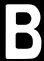

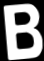

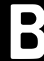

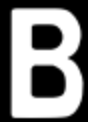

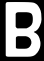

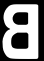

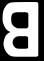

Moment 1
[0.0011131]
[0.00110216]
[0.00113992]
[0.0010979]
[0.0011131]
[0.0011131]
[0.0011131]
Moment 2
[2.14318769e-07]
[1.98972318e-07]
[2.58689084e-07]
[1.984918e-07]
[2.14318769e-07]
[2.14318769e-07]
[2.14318769e-07]
Moment 3
[4.19812104e-12]
[3.48203653e-12]
[1.14440185e-12]
[4.48719486e-12]
[4.19812104e-12]
[4.19812104e-12]
[4.19812104e-12]
Moment 4
[7.29122396e-14]
[1.23984045e-13]
[5.63326492e-13]
[1.56716547e-13]
[7.29122396e-14]
[7.29122396e-14]
[7.29122396e-14]
Moment 5
[3.51669359e-26]
[7.61296443e-26]
[-1.09556208e-25]
[1.46002548e-26]
[3.51669359e-26]
[3.51669359e-26]
[3.51669359e-26]
Moment 6
[-3.37434407e-17]
[-4.58633548e-17]
[-1.26615834e-16]
[-6.10735784e-17]
[-3.37434407e-17]
[-3.37434407e-17]
[-3.37434407e-17]
Moment 7
[1.97621882e-26]
[-2.89939543e-26]
[-4.38834259e-25]
[1.30605944e-25]
[-1.97621882e-26]
[-1.97621882e-26]
[1.97621882e-26]


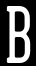

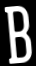

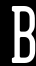

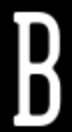

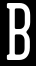

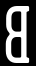

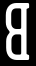

Moment 1
[0.00176779]
[0.00181288]
[0.00176779]
[0.00181303]
[0.00176779]
[0.00176779]
[0.00176779]
Moment 2
[1.61921562e-06]
[1.74311568e-06]
[1.61921562e-06]
[1.75596502e-06]
[1.61921562e-06]
[1.61921562e-06]
[1.61921562e-06]
Moment 3
[6.74370066e-11]
[8.62283125e-11]
[6.74370066e-11]
[8.9493807e-11]
[6.74370066e-11]
[6.74370066e-11]
[6.74370066e-11]
Moment 4
[3.01975034e-12]
[5.80390588e-12]
[3.01975034e-12]
[6.1209969e-12]
[3.01975034e-12]
[3.01975034e-12]
[3.01975034e-12]
Moment 5
[-4.08228552e-23]
[-1.05866051e-22]
[-4.08228552e-23]
[-1.11467265e-22]
[-4.08228552e-23]
[-4.08228552e-23]
[-4.08228552e-23]
Moment 6
[-3.7813029e-15]
[-6.59293633e-15]
[-3.7813029e-15]
[-7.27855202e-15]
[-3.7813029e-15]
[-3.7813029e-15]
[-3.7813029e-15]
Moment 7
[-1.38018966e-23]
[7.51702747e-23]
[-1.38018966e-23]
[-8.99940472e-23]
[1.38018966e-23]
[1.38018966e-23]
[-1.38018966e-23]


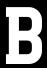

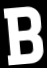

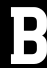

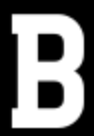

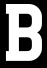

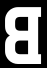

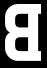

Moment 1
[0.00104134]
[0.00103805]
[0.00104134]
[0.00104418]
[0.00104134]
[0.00104134]
[0.00104134]
Moment 2
[2.31152099e-07]
[2.28516392e-07]
[2.31152099e-07]
[2.33327636e-07]
[2.31152099e-07]
[2.31152099e-07]
[2.31152099e-07]
Moment 3
[2.43779522e-11]
[2.33508682e-11]
[2.43779522e-11]
[2.48922449e-11]
[2.43779522e-11]
[2.43779522e-11]
[2.43779522e-11]
Moment 4
[1.40636272e-12]
[1.21226065e-12]
[1.40636272e-12]
[1.44717951e-12]
[1.40636272e-12]
[1.40636272e-12]
[1.40636272e-12]
Moment 5
[-7.55333781e-24]
[-6.39496515e-24]
[-7.55333781e-24]
[-8.55547805e-24]
[-7.55333781e-24]
[-7.55333781e-24]
[-7.55333781e-24]
Moment 6
[-6.45713755e-16]
[-5.77361312e-16]
[-6.45713755e-16]
[-6.93158957e-16]
[-6.45713755e-16]
[-6.45713755e-16]
[-6.45713755e-16]
Moment 7
[3.27969321e-24]
[8.3916793e-25]
[3.27969321e-24]
[1.49964549e-24]
[-3.27969321e-24]
[-3.27969321e-24]
[3.27969321e-24]


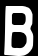

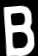

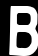

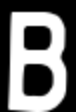

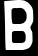

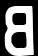

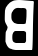

Moment 1
[0.00124724]
[0.00123651]
[0.00124724]
[0.00124557]
[0.00124724]
[0.00124724]
[0.00124724]
Moment 2
[3.67933113e-07]
[3.51849861e-07]
[3.67933113e-07]
[3.67165177e-07]
[3.67933113e-07]
[3.67933113e-07]
[3.67933113e-07]
Moment 3
[1.20096301e-11]
[1.27295381e-11]
[1.20096301e-11]
[1.23016448e-11]
[1.20096301e-11]
[1.20096301e-11]
[1.20096301e-11]
Moment 4
[5.86154293e-13]
[4.82114341e-13]
[5.86154293e-13]
[8.44986529e-13]
[5.86154293e-13]
[5.86154293e-13]
[5.86154293e-13]
Moment 5
[1.24853315e-24]
[4.36528672e-25]
[1.24853315e-24]
[1.96478386e-24]
[1.24853315e-24]
[1.24853315e-24]
[1.24853315e-24]
Moment 6
[2.88855428e-17]
[-9.18333403e-17]
[2.88855428e-17]
[-9.78408158e-18]
[2.88855428e-17]
[2.88855428e-17]
[2.88855428e-17]
Moment 7
[-9.27239429e-25]
[-1.11171634e-24]
[-9.27239429e-25]
[-1.88718856e-24]
[9.27239429e-25]
[9.27239429e-25]
[-9.27239429e-25]


In [43]:
#TODO: compute huMoments on rotated, translated, scaled, flipped (horizontal, vertical, both) input shapes
# (see cv2.getRotationMatrix2D, cv2.warpAffine, cv2.resize)
# https://docs.opencv.org/4.1.2/da/d6e/tutorial_py_geometric_transformations.html
import numpy as np

for img in images:
  cv2_imshow(img)
  (h, w) = img.shape[:2]
  (cX, cY) = (w // 2, h // 2)

  #TODO: rotate image (see cv2.getRotationMatrix2D, cv2.warpAffine)
  angle = 5
  M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
  rotated = cv2.warpAffine(img, M, (w, h))
  cv2_imshow(rotated)

  #TODO: translate image (cv2.warpAffine)
  # tx = translatie axa x, ty = translatie axa y
  #      1 0 tx
  #  M = 0 1 ty
  tx = 5
  ty = 0
  M = np.float32([[1, 0, tx], [0, 1, ty]])
  translated = cv2.warpAffine(img, M, (w, h))
  cv2_imshow(translated)

  #TODO: scale image (cv2.resoze)
  #fx - factor scalare pe axa x, fy = factor scalare pe axa y
  fx = 2
  fy = 2
  scaled = cv2.resize(img, None, fx=fx, fy=fy)
  cv2_imshow(scaled)

  #TODO: flip image (cv2.flip)
  #around x
  flipVertical = cv2.flip(img, 0)
  cv2_imshow(flipVertical)

  #around y
  flipHorizontal = cv2.flip(img, 1)
  cv2_imshow(flipHorizontal)

  #around xy
  flipBoth = cv2.flip(img, -1)
  cv2_imshow(flipBoth)

  hu_img = fd_hu_moments(img)
  hu_rot = fd_hu_moments(rotated)
  hu_trans= fd_hu_moments(translated)
  hu_scal = fd_hu_moments(scaled)
  hu_flipV = fd_hu_moments(flipVertical)
  hu_flipH = fd_hu_moments(flipHorizontal)
  hu_flipVH = fd_hu_moments(flipBoth)


  for i in range(0, 7):
    print("Moment "+str(i+1))
    print(hu_img[i])
    print(hu_rot[i])
    print(hu_trans[i])
    print(hu_scal[i])
    print(hu_flipV[i])
    print(hu_flipH[i])
    print(hu_flipVH[i])

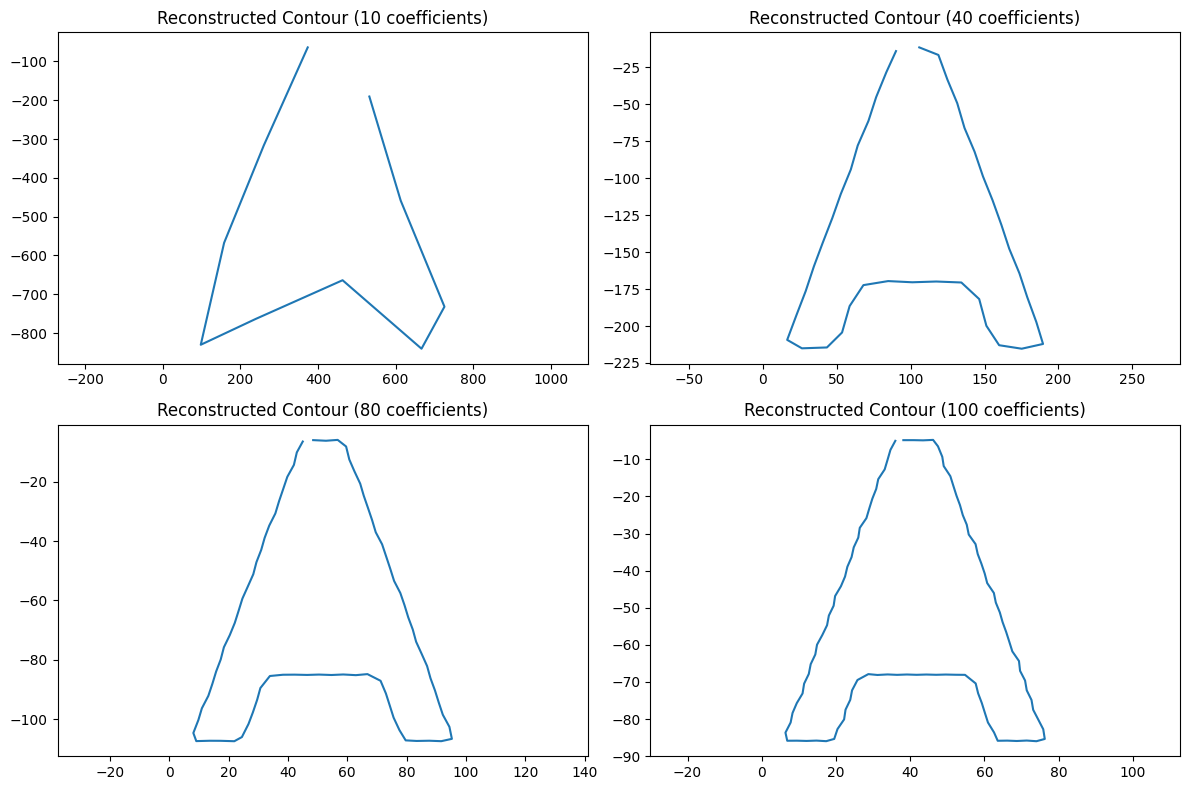

In [67]:
#TODO: reconstruct contour from truncated descriptors (10/40/80/100)
#code here -> see: ifft, matplotlib.pyplot
import matplotlib.pyplot as plt

def reconstruct_contour(descriptor):
    contour_complex = np.fft.ifft(descriptor)
    return contour_complex

img = images[0]
descriptor = findDescriptor(img)

truncated_10 = truncate_descriptor(descriptor, 10)
truncated_40 = truncate_descriptor(descriptor, 40)
truncated_80 = truncate_descriptor(descriptor, 80)
truncated_100 = truncate_descriptor(descriptor, 100)

contour_10 = reconstruct_contour(truncated_10)
contour_40 = reconstruct_contour(truncated_40)
contour_80 = reconstruct_contour(truncated_80)
contour_100 = reconstruct_contour(truncated_100)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(contour_10.real, -contour_10.imag, label='10 coefficients')
plt.title('Reconstructed Contour (10 coefficients)')
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.plot(contour_40.real, -contour_40.imag, label='40 coefficients')
plt.title('Reconstructed Contour (40 coefficients)')
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.plot(contour_80.real, -contour_80.imag, label='80 coefficients')
plt.title('Reconstructed Contour (80 coefficients)')
plt.axis('equal')

plt.subplot(2, 2, 4)
plt.plot(contour_100.real, -contour_100.imag, label='100 coefficients')
plt.title('Reconstructed Contour (100 coefficients)')
plt.axis('equal')

plt.tight_layout()
plt.show()


